In [133]:
import numpy as np
from time import process_time, perf_counter
from scipy import datasets
import matplotlib.pyplot as plt
from skimage import data, restoration

### Add Noise

Add gaussian noise to the image and some salt and pepper noise to the right side of the image.

In [134]:
def SnP_Noise(img, noise_factor = 0.15):

    row, col = img.shape

    max_number_of_pixels = row*col
    pixels_to_change = int(np.ceil(max_number_of_pixels*noise_factor*0.5))

    #Turn pixels white
    for i in range(pixels_to_change):
        #Select random pixel
        y_coord = np.random.randint(0, row-1)
        x_coord = np.random.randint(0, col-1)
        #Switch color
        img[y_coord,x_coord] = 255

    #Turn pixels black
    for i in range(pixels_to_change):
        #Select random pixel
        y_coord = np.random.randint(0, row-1)
        x_coord = np.random.randint(0, col-1)
        #Switch color
        img[y_coord,x_coord] = 0

    return img


def make_noisy(img, noise_factor = 0.15):
    # add gaussian noise
    img = img + noise_factor * np.random.normal(size=img.shape)
    # add some outliers in on the right side of the image
    w = int(np.floor(0.6*img.shape[1]))
    m = img[:, w:].copy()
    #noised_m =SnP_Noise(m,noise_factor)
    #img[:, w:] = noised_m

    return img

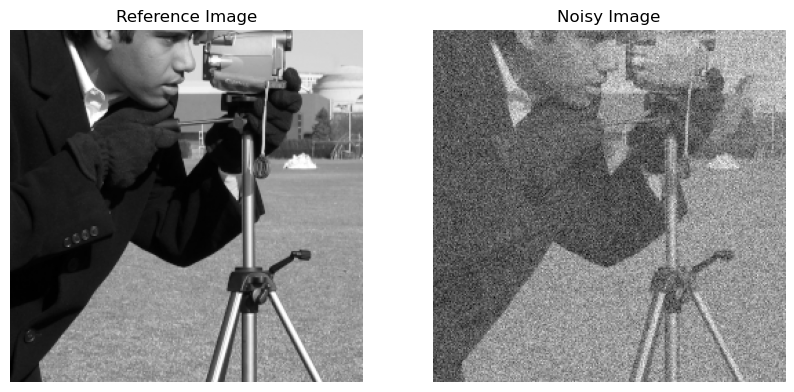

In [135]:
demo_pic = datasets.ascent()
demo_pic = data.camera()[140:,120:][:256,:256] / 255.0
noised_pic = make_noisy(demo_pic.copy(), 0.15)

plt.figure(figsize=(10, 5))
plt.gray()

# Show the first image (img_ref) in the left
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.imshow(demo_pic)
plt.title('Reference Image')
plt.axis('off')  # turn off axes

# Show the second image (img_obs) in the right
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.imshow(noised_pic)
plt.title('Noisy Image')
plt.axis('off')  # turn off axes

# Display the images

plt.show()

### Definition of Operators

We implement $K=\nabla$ via finite differences.

In [136]:
def grad(u):
    shape = [u.ndim,]+list(u.shape)
    K = np.zeros(shape, dtype=u.dtype)
    #for each dimension compute the finite difference wrt to the dimension
    #The filter is build as follows: Choose 0th dimension and pick entries 0:-1 ->K[0,:-1,:]
    #Later it will be updated such that the filter gets K[1, :, :-1]
    filter = [0, slice(0,-1),]
    for dim in range(u.ndim):
        K[tuple(filter)]=np.diff(u, axis= dim)
        Z=np.diff(u, axis= dim)
        #Update filter
        filter[0]=dim + 1
        filter.insert(1, slice(None))
    return K

The adjoint operator $K^T=\mathrm{div}$ can be implemented in several ways. We present three options: Applying finite differences a second time, a straightforward definition given by Chambolle in [1], a finite differences definition with different handling of the boundary.

---
[1] Chambolle, A. An Algorithm for Total Variation Minimization and Applications. Journal of Mathematical Imaging and Vision 20, 89–97 (2004).

In [137]:
def div(grad):
    Divergence = np.zeros(grad.shape[1:], dtype=grad.dtype)
    filter = [slice(1,None),]
    for dim in range(grad.shape[0]):
        D=grad[dim].copy()
        D[tuple(filter)]=np.diff(grad[dim], axis= dim)
        Divergence += D
        filter.insert(0, slice(None))
    return Divergence


def Chambolle_div(grad):
    div_p_0 = np.zeros_like(grad[0])
    div_p_1 = np.zeros_like(grad[0])
    for i in range(grad[0].shape[0]):
        if i== 0:
            div_p_0[i,:]=grad[0,i,:]
        elif i==grad[0].shape[0]-1:
            div_p_0[i,:]=-grad[0,i-1,:]
        else:
            div_p_0[i,:]=grad[0,i,:]-grad[0,i-1,:]
    for j in range(grad[0].shape[1]):
        if j== 0:
            div_p_1[:,j]=grad[1,:,j]
        elif j==grad[0].shape[1]-1:
            div_p_1[:,j]=-grad[1,:,j-1]
        else:
            div_p_1[:,j]=grad[1,:,j]-grad[1,:,j-1]
    Divergence = div_p_0+div_p_1
    return Divergence


def nablaT(grad):
    h, w = grad.shape[1:]
    Divergence = np.zeros((h, w),grad.dtype)
    # note that we just reversed left and right sides
    # of each line to obtain the transposed operator
    Divergence[:, :-1] -= grad[0, :, :-1]
    Divergence[:, 1: ] += grad[0, :, :-1]
    Divergence[:-1]    -= grad[1,:-1, :]
    Divergence[1: ]    += grad[1,:-1, :]
    return Divergence

In [138]:
gradient = grad(noised_pic)

begin = perf_counter()
div1 = div(gradient)
t1 = perf_counter()
print("Time needed: ",t1-begin)
div2 = Chambolle_div(gradient)
t2 = perf_counter()
print("Time needed: ",t2-t1)
div3 = nablaT(gradient)
t3 = perf_counter()
print("Time needed: ",t3-t2)
norm_diff1 = np.linalg.norm(div1-div2)
norm_diff2 = np.linalg.norm(div1-div3)
print("||div1-div2||=",norm_diff1)
print("||div1-div3||=",norm_diff2)

Time needed:  0.0005272130001685582
Time needed:  0.0022614320005232003
Time needed:  0.0005174549987714272
||div1-div2||= 0.0
||div1-div3||= 286.57073507584204


The first two implementations lead to the same result. However, the first one is faster and more flexible which is why we will stick to this in the next steps. The thrid one leads to a different result. We will compare the performance of them later. As a proof of concept we first compare their operator norms.

In [139]:
def operator_norm_estimator(K, K_T, max_iter=25):
    """
    Estimate the operator norm through power method.
    """
    shape=(500,500)
    u = np.random.randn(*shape)
    u /= np.linalg.norm(u)
    for _ in range(max_iter):
        Ku = K(u)
        KT_Ku = K_T(Ku)
        norm = np.linalg.norm(KT_Ku)
        u = KT_Ku / norm

    return np.sqrt(np.sum(np.sum(K(u)**2, axis=0)))

In [140]:
L1 = operator_norm_estimator(grad, div, 50)
L2 = operator_norm_estimator(grad, nablaT, 50)
print("L1^2=",L1**2, ", L2^2=", L2**2)

L1^2= 7.9198253834627685 , L2^2= 7.946205441472504


### Energy and proximal operators
Note that by definition $\vert (\nabla u)_{i,j}\vert = \sqrt{((\nabla u)^1_{i,j})^2+((\nabla u)^2_{i,j})^2}$. The ROF model is defined as the variational problem $ \min_{u} \int_\Omega \vert Du\vert +\frac{\lambda}{2} \Vert u-g\Vert_2^2.$ So the energy that needs to be minimized is $E_{ROF}(u)=\Vert \nabla u\Vert_1 +\frac{\lambda}{2} \Vert u-g\Vert_2^2$ where $\Vert \nabla u\Vert_1 =\sum_{i,j}\vert (\nabla u)_{i,j}\vert$.

In [141]:
def abs_grad(x):
    return np.sqrt(np.sum(x**2, axis=0))

def calc_energy_ROF(u, g, lamb):
    TV = abs_grad(grad(u)).sum()
    Fidelity = 0.5 * lamb * ((u - g)**2).sum()
    return TV + Fidelity, TV, Fidelity

The primal-dual forulation of the ROF problem is given by $$\min_{u\in X}\max_{p\in Y} - \langle u, \textrm{div }p \rangle_X +\frac{\lambda}{2} \Vert u-g\Vert_2^2-\delta_P(p)$$ where $P=\{p\in Y:\Vert p\Vert_\infty\leq 1\}$ and $\delta_P$ is the indicator function. So $F^*(p)=\delta_P(p)$ and $G(u)= \frac{\lambda}{2} \Vert u-g\Vert_2^2$ and therefore a short calculation yields $$p=(I+\sigma\partial F^*)^{-1}(\tilde{p})\Leftrightarrow p_{i,j}=\frac{\tilde{p}_{i,j}}{\mathrm{max}(1,\vert \tilde{p}_{i,j}\vert)}$$ and $$u=(I+\tau\partial G)^{-1}(\tilde{u}) \Leftrightarrow u_{i,j}=\frac{\tilde{u}_{i,j}+\tau \lambda g_{i,j}}{1+\tau\lambda}.$$

In [142]:
def F_conj(p):
    norm = np.max(abs_grad(p))
    if norm<= 1:
        return 0
    else:
        return np.inf

def G(u, g, lamb):
    fidelity = calc_energy_ROF(u, g, lamb)[2]
    return fidelity

def prox_F_conj(p):
    proj = np.zeros_like(p)
    nP = np.maximum(1.0, abs_grad(p))
    for i in range(p.shape[0]):
        proj[i] = p[i]/nP
    return proj

def ROF_prox_G(u, g, lamb, tau):
    lt = lamb * tau
    return (u + lt * g) / (1.0 + lt)

### The primal-dual algorithm

We use the following algorithm from [2]. Let $X,Y$ be two Hilbert spaces and $K\colon X\to Y$ a continuous linear operator with induced norm $\Vert K\Vert =\mathrm{max}\{\Vert Kx\Vert\colon x\in X\text{ with }\Vert x\Vert \leq 1\}$. The problem which is considered is the saddle-point problem $$\min_{x\in X}\max_{y\in Y}\langle Kx,y\rangle+G(x)-F^*(y)$$ where $G\colon X\to [0,+\infty]$ and $F^*\colon Y\to [0,+\infty]$ are proper, convex, lower-semicontinuous functions and $F^*$ being itself the convex conjugate of a convex l.s.c. function $F$.

**Algorithm**

Initialization: Choose $\tau,\sigma >0$, $\theta\in [0,1]$, $(x^0,y^0)\in X\times Y$ and set $\overline{x}^0=x^0$.\\
Iterations ($n\geq  0$): Update $x^n, y^n, \overline{x}^n$ as follows: $$\left\{ \begin{array}{l}
	y^{n+1}=(I+\sigma \partial F^*)^{-1}(y^n+\sigma K\overline{x}^n)\\
	x^{n+1}=(I+\tau \partial G)^{-1}(x^n-\tau K^* y^{n+1})\\
    \overline{x}^{n+1}= x^{n+1}+\theta(x^{n+1}-x^n)
	\end{array} \right.$$
If the problem has a saddle-point, then by choosing $\theta=1$ and $\tau\sigma L^2<1$ for $L=\Vert K\Vert$ we find saddle-points of the problem by applying the algorithm.


---
[2] Chambolle, A., Pock, T. A First-Order Primal-Dual Algorithm for Convex Problems with Applications to Imaging. J Math Imaging Vis 40, 120–145 (2011). 

In [143]:
def primaldual(E, f_conj, g, prox_f_conj, prox_g, K, K_T, x0, y0, sigma, tau, numb_iter=100, tracking=True):

    begin = perf_counter() 

    #Initialization
    theta = 1.0
    x, y, z = x0, y0, x0

    if tracking == True:
        energy, tv, fidelity = E(x0,y0)
        Prod = np.sum(K(x0)*y0)
        G = g(x0)
        F = f_conj(y0)

        energies = [energy,]
        TVs = [tv,]
        fidelities = [fidelity,]
        descent = [Prod+G,]
        ascent = [Prod-F,]

        time_list = [process_time() - begin]

    for i in range(numb_iter):
        #Update Steps
        y = prox_f_conj(y + sigma * K(z), sigma)
        x1 = prox_g(x - tau * K_T(y), tau)
        z = x1 + theta * (x1 - z)
        x = x1

        if tracking == True:
            e,t,f = E(x,y)
            energies.append(e)
            TVs.append(t)
            fidelities.append(f)

            Prod = np.sum(K(x)*y)
            G = g(x)
            F = f_conj(y)
            descent.append(Prod+G)
            ascent.append(Prod-F)
            
            time_list.append(perf_counter() - begin)
    end = perf_counter()

    print("----- Primal-dual method -----")
    print("Time execution:", end - begin)
    if tracking == True:
        return [x, y, time_list, energies, TVs, fidelities, descent, ascent]
    else:
        return [x,y]

----- Primal-dual method -----
Time execution: 0.6668987150005705


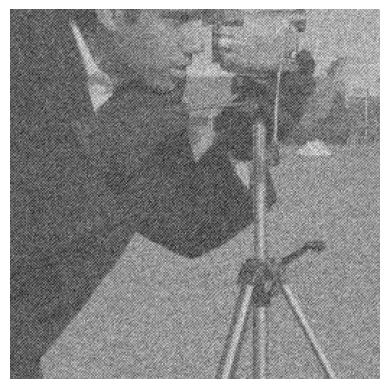

In [144]:
#Setup
Lamb=8
K = lambda x: grad(x)
K_T = lambda x: nablaT(x)
approx_grad_norm = operator_norm_estimator(K, K_T, 50)
L = approx_grad_norm
sigma = 1/L
tau = 1/L
u0 = noised_pic
p0 = K(noised_pic)

prox_g = lambda u, tau: ROF_prox_G(u, noised_pic, Lamb, tau)
prox_f = lambda p, sigma: prox_F_conj(p)
g_lambda = lambda u: G(u, noised_pic, Lamb)
f_conj = F_conj

energy = lambda u, p: calc_energy_ROF(u, noised_pic, Lamb)

res = primaldual(energy, f_conj, g_lambda, prox_f, prox_g, K, K_T, u0, p0, sigma, tau, numb_iter=150)

denoised_ROF = res[0]
plt.gray()
plt.axis("off")
plt.imshow(denoised_ROF)
plt.show()


Iteration 0  ROF-Energy:  (np.float64(17483.127099048903), np.float64(17477.477718100352), np.float64(5.649380948551217))
Iteration 10  ROF-Energy:  (np.float64(16547.08768517365), np.float64(16488.25471902575), np.float64(58.83296614790021))
Iteration 20  ROF-Energy:  (np.float64(16523.086110114513), np.float64(16462.057459025436), np.float64(61.028651089074884))
Iteration 30  ROF-Energy:  (np.float64(16522.411047675294), np.float64(16461.318817714313), np.float64(61.09222996098257))
Iteration 40  ROF-Energy:  (np.float64(16522.391836209405), np.float64(16461.297679549643), np.float64(61.094156659760024))
Iteration 50  ROF-Energy:  (np.float64(16522.391302453987), np.float64(16461.29708532007), np.float64(61.094217133917326))
Iteration 60  ROF-Energy:  (np.float64(16522.39128870553), np.float64(16461.29706963402), np.float64(61.094219071511326))
Iteration 70  ROF-Energy:  (np.float64(16522.391288415878), np.float64(16461.297069281703), np.float64(61.09421913417422))
Iteration 80  ROF-

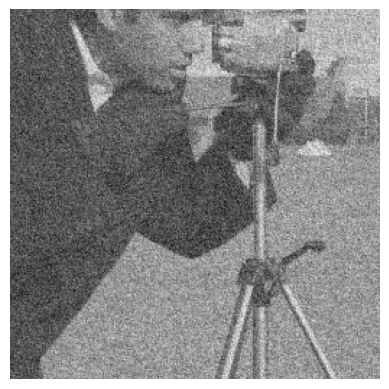

In [145]:
def nabla(I):
    h, w = I.shape
    G = np.zeros((h, w, 2), I.dtype)
    G[:, :-1, 0] -= I[:, :-1]
    G[:, :-1, 0] += I[:, 1:]
    G[:-1, :, 1] -= I[:-1]
    G[:-1, :, 1] += I[1:]
    return G



def anorm(x):
    '''Calculate L2 norm over the last array dimention'''
    return np.sqrt((x*x).sum(-1))

def project_nd(P, r):
    '''perform a pixel-wise projection onto R-radius balls'''
    nP = np.maximum(1.0, anorm(P)/r)
    return P / nP[...,np.newaxis]

def solve_ROF(img, clambda, iter_n=101):
    # setting step sizes and other params
    L2 = 8.0
    tau = 0.02
    sigma = 1.0 / (L2*tau)
    theta = 1.0

    X = img.copy()
    X1 = img.copy()
    P = grad(X)
    for i in range(iter_n):
        P = project_nd( P + sigma*grad(X), 1.0 )
        lt = clambda * tau
        Xold = X1
        X1 = (X - tau * nablaT(P) + lt * img) / (1.0 + lt)
        X = X1 + theta * (X1 - X)
        if i % 10 == 0:
            msg = calc_energy_ROF(X, img, clambda)
            print("Iteration",i," ROF-Energy: ", msg)
    
    return X

denoised_ROF = solve_ROF(noised_pic, 8.0)
plt.gray()
plt.axis("off")
plt.imshow(denoised_ROF)
plt.show()